In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import pandas as pd
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("narySt/codeT5p_CommitMessageGen")
model = AutoModelForSeq2SeqLM.from_pretrained("narySt/codeT5p_CommitMessageGen", device_map='auto')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
import datasets 
data = datasets.load_dataset('csv', data_files=['commits_cleaned_v5.csv'])

In [6]:
import evaluate

In [7]:
bertscore = evaluate.load("bertscore")
bleu = evaluate.load('sacrebleu')

In [8]:
data = data.remove_columns(['Unnamed: 0', "repo_name", "hash", 'files_changed', "changes_len"])

In [9]:
data = data['train']

In [10]:
def tokenize(sample):
    # sample['labels'] = tokenizer(sample['commit_message'], padding='max_length', truncation=True)['input_ids']
    res = tokenizer(sample['commit_changes'], padding='max_length', truncation=True)
    sample['input_ids'] = res['input_ids']
    sample['attention_mask'] = res['attention_mask']
    return sample

data = data.map(tokenize, num_proc=8)

In [11]:
data.set_format('torch')

In [12]:
data = data.remove_columns(["commit_changes"])

In [13]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(data, batch_size=batch_size)

In [14]:
import transformers
generation_conf = transformers.GenerationConfig(
    max_new_tokens=512,
    top_k=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    do_sample=True,
    early_stopping=True,
    top_p=0.95,
)

In [15]:
import sys

DIR_PREFIX = "/home/user/commits/commit_messages_generation/"

sys.path.insert(0, DIR_PREFIX)
from metrics.bnorm.bleu_norm import BLEUNorm

bnorm = BLEUNorm()

/tmp/ipykernel_309173/1965626508.py:8: FutureWarning: Metric is deprecated and will be removed in the next major version of datasets. Use the new library 🤗 Evaluate instead: https://huggingface.co/docs/evaluate
  bnorm = BLEUNorm()


In [16]:
from tqdm.notebook import tqdm
bertscores = []
bleus = []

for batch in tqdm(dataloader):
    input_ids = batch['input_ids']
    attn = batch['attention_mask']
    labels = batch['commit_message']
    
    input_ids = input_ids.to(device)
    attn = attn.to(device)
    input_ = {"input_ids" : input_ids, "attention_mask" : attn}
    
    gen_res = model.generate(**input_, generation_config=generation_conf)
    gen_text = tokenizer.batch_decode(gen_res, skip_special_tokens=True)
    bert_metrics = bertscore.compute(
        predictions=gen_text, references=labels, lang="en", device=device, batch_size=batch_size
    )['f1']
    bleu_metrics = bnorm.compute(predictions=gen_text, references=labels)[
        "b_norm"
    ]
    bertscores.append(bert_metrics)
    bleus.append(bleu_metrics)

    torch.cuda.empty_cache()

  0%|          | 0/4643 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np

In [25]:
bertscores = bertscores[:-1]

In [29]:
bertscores_np = np.array(bertscores)

In [35]:
bertscores_np = np.reshape(bertscores_np, -1)
bertscores_np.shape

(148544,)

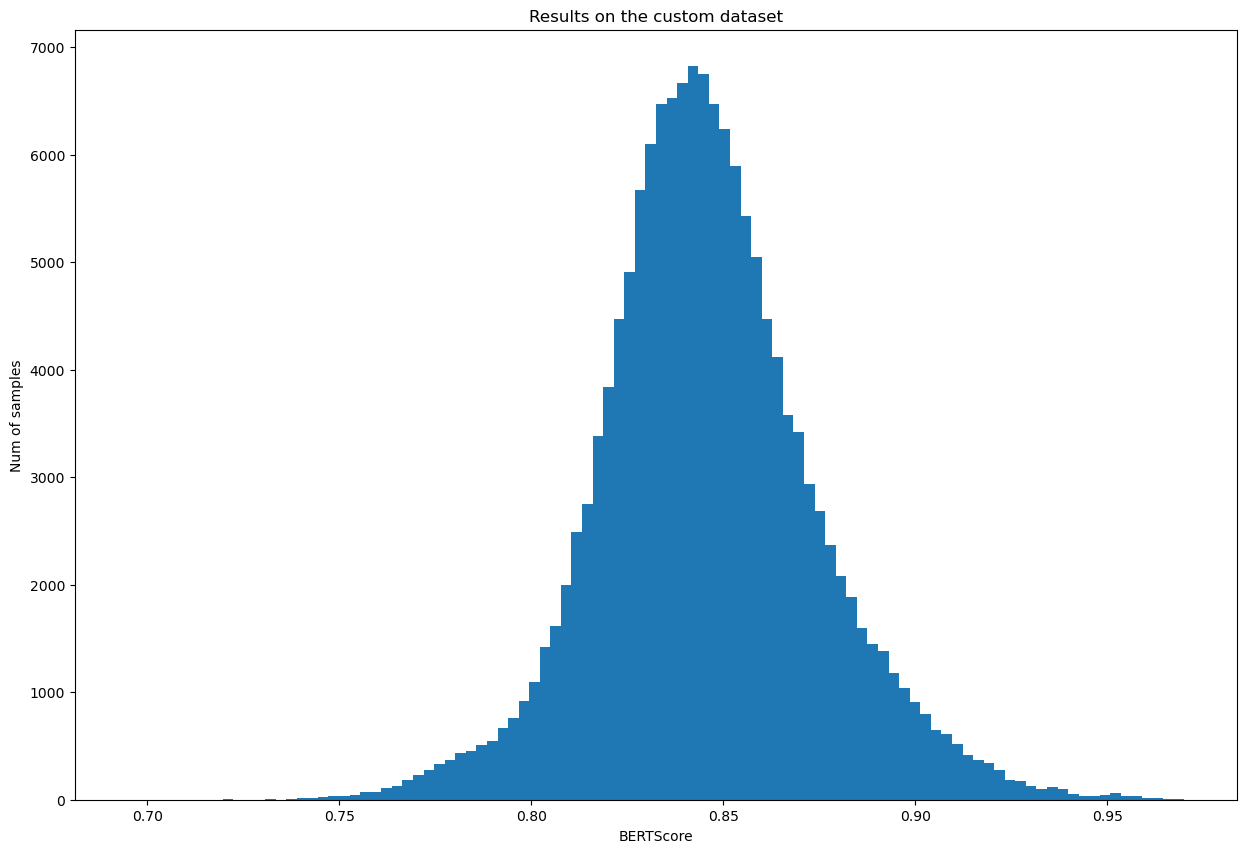

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.hist(bertscores_np,bins=100)
plt.title("Results on the custom dataset")
plt.xlabel('BERTScore')
plt.ylabel("Num of samples")
plt.savefig("eval_res_custom.png")

In [38]:
np.save('bert_results.npy', bertscores)